# Setup

In [91]:
!pip install fastai==2.7.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Getting Data in Drive

In [92]:
from google.colab import drive

#you will have to change this for your own folder
drive.mount('/content/drive')
%cd /content/drive/My Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


# Processing training data

In [93]:
from fastai.vision.all import *

In [94]:
from os import listdir

def remove_invalid(df):
    file_names = listdir('data/images')
    return df[df['image_id'].isin(file_names)]

In [95]:
import PIL
class HistogramEqualization(Transform):
  def init(self, prefix=None):
    self.prefix = prefix or ""

    def encodes(self, o):
      if type(o) == PILImage:
        ret = PIL.ImageOps.equalize(o)
      else:
        ret = o
      return ret

    def decodes(self, o):
      return o

In [106]:
import pandas as pd

repl_count = 10

train_df = pd.read_csv('data/train_og.csv')
train_df = remove_invalid(train_df)
train_df = pd.concat([train_df]*repl_count, ignore_index=True)

train_db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                    splitter=EndSplitter(valid_pct=0.2),
                    get_x=ColReader(0, pref="data/images/"),
                    get_y=ColReader(1, label_delim=' '),
                    item_tfms=[Resize(600, 'pad', 'border'), HistogramEqualization()], # 224
                    batch_tfms=aug_transforms(mult=1.0, pad_mode='border', p_affine=1.0, p_lighting=1.0))
print(train_db)
print(train_df)
dls = train_db.dataloaders(train_df, bs=64)

        image_id                 labels
0     img256.jpg    l16 l18 l23 l25 l73
1      img98.jpg         l0 l24 l26 l39
2     img147.jpg                 l14 l3
3     img254.jpg             l2 l25 l29
4     img160.jpg      l0 l32 l38 l40 l6
...          ...                    ...
2005  img105.jpg                    l51
2006  img198.jpg      l0 l10 l11 l65 l7
2007   img82.jpg                     l2
2008  img124.jpg   l0 l1 l19 l22 l34 l6
2009   img23.jpg  l1 l15 l18 l2 l21 l71

[2010 rows x 2 columns]


In [98]:
labels_df = pd.read_csv('data/labels.csv')
print(labels_df)

   label_id    object
0        l0    people
1        l1     trees
2        l2     grass
3        l3  building
4        l4      snow
..      ...       ...
87      l87     stage
88      l88      book
89      l89     books
90      l90      flag
91      l91      pole

[92 rows x 2 columns]


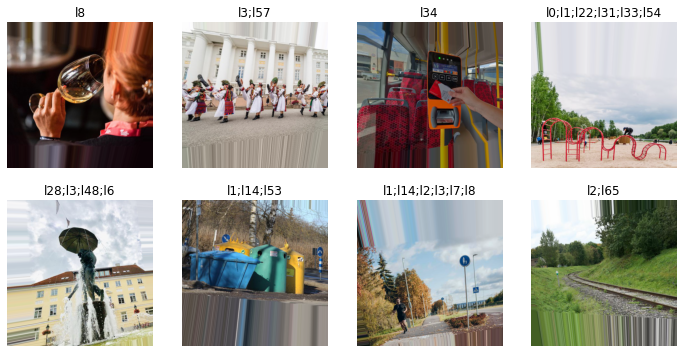

In [107]:
dls.show_batch(max_n=8, figsize=(12,6))

# The good stuff

In [108]:
class ResBlock(Module):
  def __init__(self, nf):
    self.conv1 = ConvLayer(nf, nf)
    self.conv2 = ConvLayer(nf, nf)
  
  def forward(self, x): return x + self.conv2(self.conv1(x))

In [109]:
def conv2(ni, nf): return ConvLayer(ni, nf, stride=2)

In [110]:
def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [111]:
def get_model(model, pretrained=False, progress=True, **kwargs):
    """model: function to load the model, e.g. resnet18
        pretrained, progress: to be passed to the model function
    """
    m = model(pretrained=pretrained, progress=progress, **kwargs) # loads standard model
    m.avgpool = nn.AdaptiveAvgPool2d(output_size=(200,200)) # changes one layer
    m.add_module('convres_1', conv_and_res(1,8))
    m.add_module('convres_2', conv_and_res(8,16))
    m.add_module('convres_3', conv_and_res(16,32))
    m.add_module('convres_4', conv_and_res(32,16))
    m.add_module('convres_5', conv_and_res(64,32))
    return m

In [112]:
class SAM(Callback):
    "Sharpness-Aware Minimization"
    def __init__(self, zero_grad=True, rho=0.05, eps=1e-12, **kwargs): 
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"
        self.state = defaultdict(dict)
        store_attr()

    def params(self): return self.learn.opt.all_params(with_grad=True)
    def _grad_norm(self): return torch.norm(torch.stack([p.grad.norm(p=2) for p,*_ in self.params()]), p=2)
    
    @torch.no_grad()
    def first_step(self):
        scale = self.rho / (self._grad_norm() + self.eps)
        for p,*_ in self.params():
            self.state[p]["e_w"] = e_w = p.grad * scale
            p.add_(e_w)  # climb to the local maximum "w + e(w)"
        if self.zero_grad: self.learn.opt.zero_grad()
        
    @torch.no_grad()    
    def second_step(self):
        for p,*_ in self.params(): p.sub_(self.state[p]["e_w"])

    def before_step(self, **kwargs):
        self.first_step()
        self.learn.pred = self.model(*self.xb); self.learn('after_pred')
        self.loss_func(self.learn.pred, *self.yb).backward()
        self.second_step()

In [113]:
learn = vision_learner(dls, partial(get_model, model=resnet34), metrics=partial(accuracy_multi, thresh=0.1), loss_func=BCEWithLogitsLossFlat())

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [146]:
learn.fit_one_cycle(50, cbs=[SAM()])

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.000377,0.000002,1.000000,00:17
1,0.000459,0.000002,1.000000,00:17
2,0.000428,0.000002,1.000000,00:17
3,0.000435,0.000002,1.000000,00:17
4,0.000412,0.000002,1.000000,00:17
5,0.000391,0.000002,1.000000,00:17
6,0.000397,0.000002,1.000000,00:17
7,0.000371,0.000002,1.000000,00:17
8,0.000408,0.000002,1.000000,00:17
9,0.000412,0.000002,1.000000,00:17


In [17]:
test_df = pd.read_csv('data/test.csv')
print(test_df)

      image_id
0   img102.jpg
1   img103.jpg
2    img11.jpg
3   img113.jpg
4   img114.jpg
..         ...
83   img81.jpg
84   img84.jpg
85   img90.jpg
86   img93.jpg
87   img94.jpg

[88 rows x 1 columns]


image_id            img212.jpg
labels      l1 l15 l2 l5 l7 l9
Name: 36, dtype: object


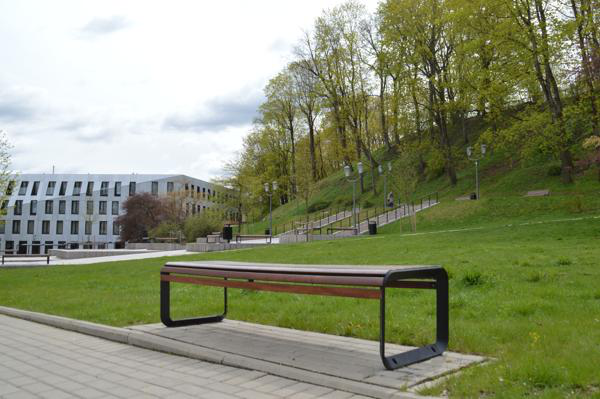

In [160]:
img_series = test_df.sample().iloc[0]
img_path = 'data/images/' + img_series['image_id']
img = load_image(img_path)
print(img_series)
img

In [161]:
pred_class,pred_idx,outputs = learn.predict(img_path)
list(map(lambda label: labels_df.loc[labels_df['label_id'] == label], pred_class))

[  label_id object
 1       l1  trees,    label_id      object
 15      l15  lamp posts,   label_id object
 2       l2  grass,   label_id     object
 5       l5  buildings,   label_id object
 7       l7   road,   label_id object
 9       l9   cars]

In [149]:
file_names = listdir('data/images')
for i in test_df.index:
  if test_df.at[i, 'image_id'] in file_names:
    img_path = 'data/images/' + test_df.at[i, 'image_id']
    print(img_path)
    pred_class,pred_idx,outputs = learn.predict(img_path)
    print(pred_class)
    test_df.at[i, 'labels'] = ' '.join(pred_class)
  else:
    test_df.at[i, 'labels'] = ''
print(test_df)

data/images/img102.jpg


['l0']
data/images/img103.jpg


['l10']
data/images/img11.jpg


['l4', 'l5']
data/images/img113.jpg


[]
data/images/img114.jpg


['l13']
data/images/img121.jpg


['l0', 'l1', 'l2', 'l31', 'l5', 'l54', 'l6']
data/images/img126.jpg


['l0', 'l2', 'l6']
data/images/img131.jpg


[]
data/images/img136.jpg


[]
data/images/img137.jpg


['l1', 'l2']
data/images/img139.jpg


['l1']
data/images/img140.jpg


['l0', 'l1', 'l19', 'l22']
data/images/img15.jpg


['l1', 'l53', 'l91']
data/images/img150.jpg


['l3']
data/images/img151.jpg


['l0', 'l7']
data/images/img152.jpg


['l0', 'l14', 'l5', 'l7']
data/images/img156.jpg


['l1', 'l11', 'l14', 'l7']
data/images/img161.jpg


['l0', 'l1', 'l38', 'l40', 'l6']
data/images/img166.jpg


['l1', 'l12', 'l3', 'l7']
data/images/img167.jpg


['l9']
data/images/img170.jpg


['l0', 'l1', 'l21', 'l3', 'l83']
data/images/img173.jpg


['l1', 'l4']
data/images/img176.jpg


['l0', 'l1', 'l4']
data/images/img18.jpg


['l1']
data/images/img180.jpg


['l0', 'l1', 'l30', 'l5']
data/images/img181.jpg


['l0', 'l1', 'l2']
data/images/img182.jpg


['l0', 'l1', 'l3', 'l7']
data/images/img183.jpg


['l2']
data/images/img189.jpg


['l1', 'l20', 'l5', 'l6']
data/images/img192.jpg


['l0', 'l1', 'l11']
data/images/img194.jpg


['l0', 'l1', 'l2', 'l3']
data/images/img195.jpg


['l0', 'l2']
data/images/img206.jpg


['l0', 'l1', 'l2']
data/images/img208.jpg


['l1', 'l2']
data/images/img209.jpg


['l1', 'l2', 'l5']
data/images/img211.jpg


['l1', 'l15', 'l18', 'l2', 'l5', 'l7']
data/images/img212.jpg


['l1', 'l15', 'l2', 'l5', 'l7', 'l9']
data/images/img218.jpg


['l30', 'l70', 'l78', 'l8', 'l88']
data/images/img22.jpg


['l1', 'l18', 'l2', 'l21', 'l71']
data/images/img221.jpg


[]
data/images/img228.jpg


['l1', 'l4', 'l42']
data/images/img230.jpg


['l1', 'l16', 'l3', 'l4', 'l42', 'l9']
data/images/img231.jpg


['l1', 'l4']
data/images/img234.jpg


['l1', 'l3', 'l4', 'l42', 'l9']
data/images/img238.jpg


['l0', 'l11']
data/images/img243.jpg


['l0', 'l1', 'l2']
data/images/img247.jpg


['l1', 'l2']
data/images/img248.jpg


['l2', 'l25', 'l29']
data/images/img249.jpg


['l25', 'l29']
data/images/img250.jpg


['l25']
data/images/img251.jpg


['l7']
data/images/img252.jpg


['l1', 'l5']
data/images/img257.jpg


['l1']
data/images/img259.jpg


['l8']
data/images/img262.jpg


[]
data/images/img265.jpg


[]
data/images/img266.jpg


['l1', 'l5', 'l9']
data/images/img279.jpg


['l0', 'l5']
data/images/img280.jpg


['l0', 'l5']
data/images/img281.jpg


['l0', 'l24', 'l26', 'l39']
data/images/img292.jpg


['l0', 'l3', 'l5']
data/images/img296.jpg


['l24', 'l28', 'l48']
data/images/img3.jpg


['l17', 'l27', 'l3', 'l4']
data/images/img300.jpg


['l28', 'l3', 'l48']
data/images/img33.jpg


['l0']
data/images/img37.jpg


['l1']
data/images/img39.jpg


['l8']
data/images/img41.jpg


['l0', 'l27']
data/images/img42.jpg


[]
data/images/img43.jpg


[]
data/images/img48.jpg


['l0', 'l16', 'l3', 'l45', 'l67', 'l7', 'l9']
data/images/img49.jpg


['l0', 'l1']
data/images/img5.jpg


['l0', 'l17', 'l27', 'l4', 'l58', 'l63', 'l79']
data/images/img57.jpg


[]
data/images/img59.jpg


['l0', 'l3', 'l7', 'l9']
data/images/img69.jpg


['l0', 'l1', 'l41', 'l86']
data/images/img71.jpg


['l0']
data/images/img73.jpg


['l0']
data/images/img75.jpg


['l0']
data/images/img79.jpg


['l2']
data/images/img8.jpg


[]
data/images/img81.jpg


['l2']
data/images/img84.jpg


['l13', 'l60', 'l75']
data/images/img90.jpg


['l0', 'l62']
data/images/img93.jpg


[]
data/images/img94.jpg


[]
      image_id       labels
0   img102.jpg           l0
1   img103.jpg          l10
2    img11.jpg        l4 l5
3   img113.jpg             
4   img114.jpg          l13
..         ...          ...
83   img81.jpg           l2
84   img84.jpg  l13 l60 l75
85   img90.jpg       l0 l62
86   img93.jpg             
87   img94.jpg             

[88 rows x 2 columns]


In [162]:
test_df.to_csv('data/submission.csv', index = False)

In [45]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kristoisberg","key":"e896f3fc0e72d1ac41b5c41a2585a55a"}'}

In [46]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [163]:
!kaggle competitions submit -c tartu-object-detection-part-2 -f data/submission.csv -m "FastAI v2 submission"

100% 1.62k/1.62k [00:03<00:00, 518B/s]
Successfully submitted to Object recognition for The Image Bank of Tartu (2)